In [1]:
from datasets import Dataset, DatasetDict
!pip install -q datasets transformers accelerate timm
!pip install -q -U albumentations>=1.4.5 torchmetrics pycocotools


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
zsh:1: 1.4.5 not found


In [3]:
from PIL import Image

Image.open('data/iam_form.png').width, Image.open('data/iam_form.png').height

(2479, 3542)

In [64]:
import pandas as pd
import os

def get_dataset(dataset_path):
    if not os.path.exists(dataset_path):
        print("Dataset not found")
        return None
    dataset = []

    for folder in os.listdir(dataset_path):
        if not os.path.isdir(os.path.join(dataset_path, folder)):
            continue
        for i, file in enumerate(os.listdir(dataset_path + '/' + folder)):
            if not file.endswith('.png'):
                continue
            csv_file = dataset_path + '/' + folder + '/' + file[:-4] + '.csv'
            res_df = pd.read_csv(csv_file)
            image_path = os.path.join(dataset_path, folder, file)
            y = res_df['y'].to_numpy()
            image = Image.open(image_path)
            width = image.width
            height = image.height
            bbox = [[0, y_i, width, 150] for y_i in y]
            objects = {
                'bbox': bbox,
                'category': [0] * len(y),
                'area': [150 * width] * len(y)
            }
            dataset.append({
                'image_id': i,
                'image': image,
                'width': width,
                'height': height,
                'objects': objects
            })

    return {
        'train': dataset[:int(0.8 * len(dataset))],
        'validation': dataset[int(0.8 * len(dataset)):int(0.9 * len(dataset))],
        'test': dataset[int(0.9 * len(dataset)):],
    }

dataset = get_dataset('synthetic_dataset')
dataset['train'][0]

{'image_id': 1,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=2479x3542>,
 'width': 2479,
 'height': 3542,
 'objects': {'bbox': [[0, 900, 2479, 150],
   [0, 1100, 2479, 150],
   [0, 1250, 2479, 150],
   [0, 1600, 2479, 150],
   [0, 1800, 2479, 150],
   [0, 1950, 2479, 150],
   [0, 2150, 2479, 150],
   [0, 2300, 2479, 150],
   [0, 2500, 2479, 150],
   [0, 2650, 2479, 150]],
  'category': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'area': [371850,
   371850,
   371850,
   371850,
   371850,
   371850,
   371850,
   371850,
   371850,
   371850]}}

[0, 900, 2479, 150]
[0, 1100, 2479, 150]
[0, 1250, 2479, 150]
[0, 1600, 2479, 150]
[0, 1800, 2479, 150]
[0, 1950, 2479, 150]
[0, 2150, 2479, 150]
[0, 2300, 2479, 150]
[0, 2500, 2479, 150]
[0, 2650, 2479, 150]


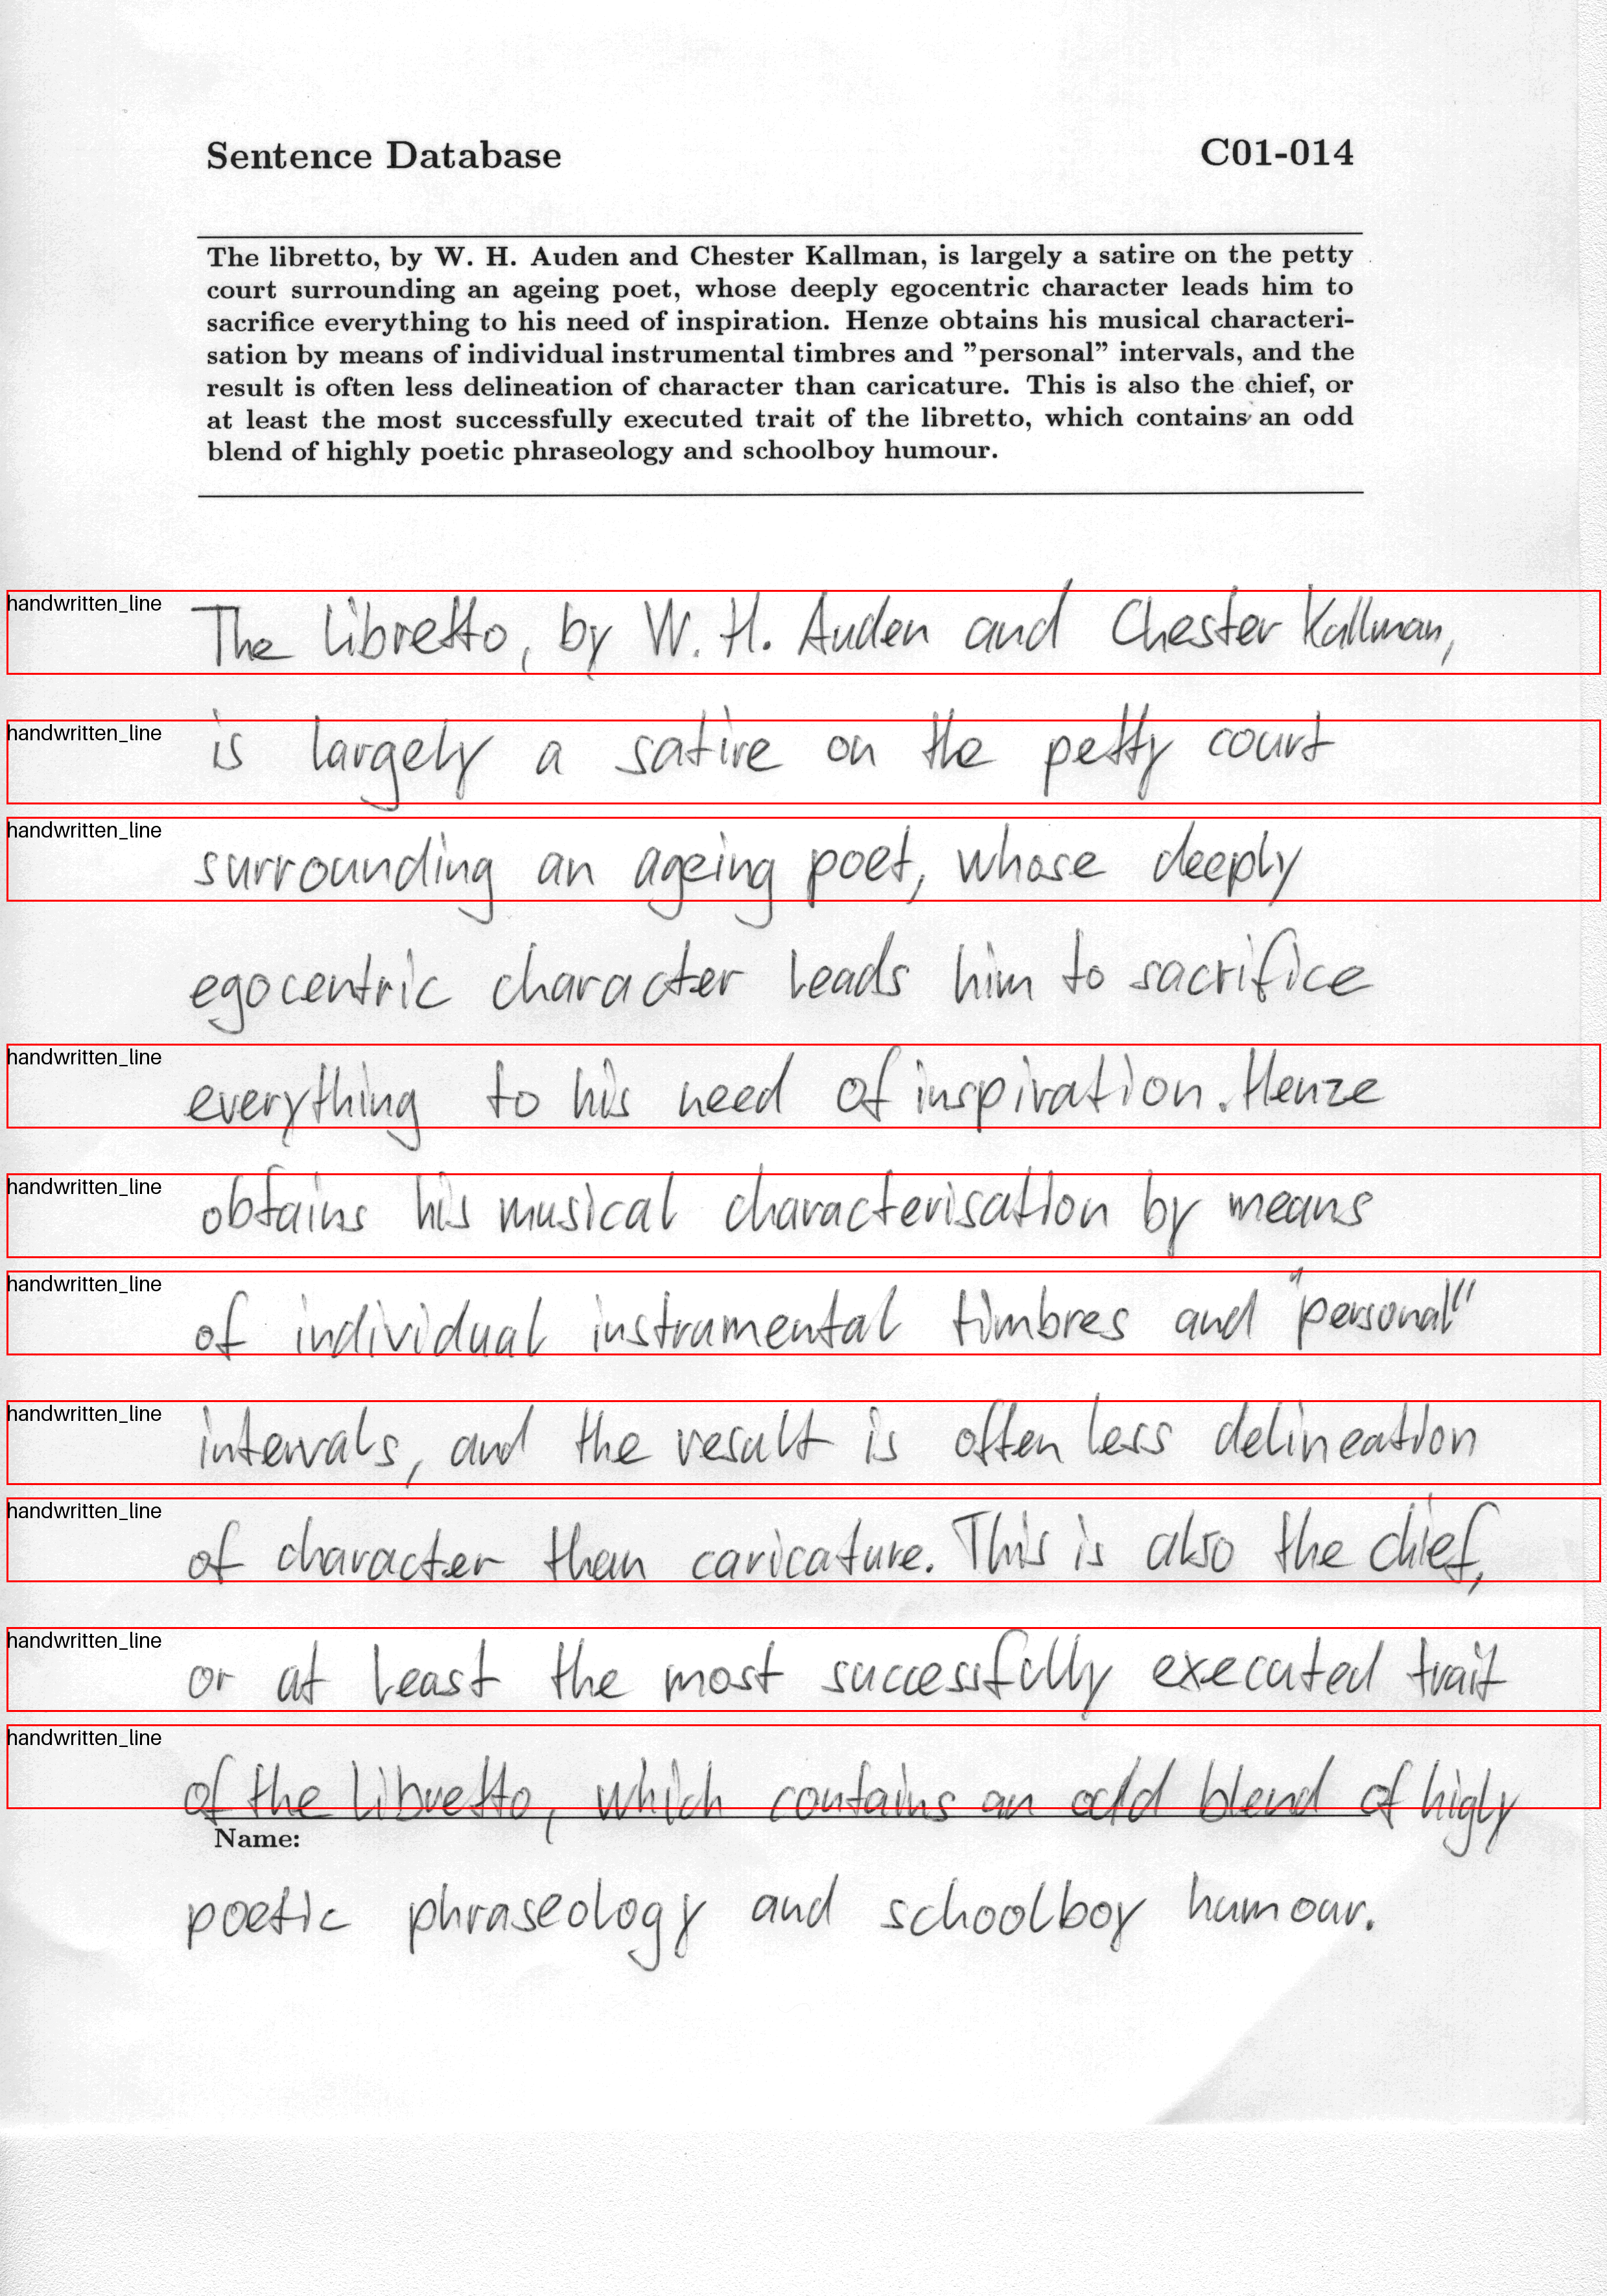

In [65]:
import numpy as np
import os
from PIL import Image, ImageDraw

index = 0

image = dataset["train"][index]["image"].convert("RGB")
annotations = dataset["train"][index]["objects"]
draw = ImageDraw.Draw(image)

categories = ["handwritten_line"]

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["bbox"])):
    box = annotations["bbox"][i]
    print(box)
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    x1, y1 = int(x + 10), int(y + 10)
    x2, y2 = int(x + w - 10), int(y + h -10)
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    draw.text((x1, y1), id2label[class_idx], fill="black", font_size=32)

image

In [66]:
from transformers import AutoImageProcessor

MODEL_NAME = "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"
IMAGE_SIZE = 480

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

In [67]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [68]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }


In [69]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [70]:
from datasets import Dataset, DatasetDict

# Convert lists to Dataset objects
ds = DatasetDict()
ds["train"] = Dataset.from_list(dataset["train"])
ds["validation"] = Dataset.from_list(dataset["validation"])
ds["test"] = Dataset.from_list(dataset["test"])

ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 22
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
})

In [71]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

ds["train"] = ds["train"].with_transform(train_transform_batch)
ds["validation"] = ds["validation"].with_transform(validation_transform_batch)
ds["test"] = ds["test"].with_transform(validation_transform_batch)

ds["train"][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[1.7523, 1.7523, 1.7523,  ..., 0.0000, 0.0000, 0.0000],
          [1.7523, 1.7009, 1.7523,  ..., 0.0000, 0.0000, 0.0000],
          [1.7523, 1.7180, 1.7694,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.7352, 1.7523, 1.7865,  ..., 0.0000, 0.0000, 0.0000],
          [1.7694, 1.7523, 1.7694,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[1.9209, 1.9209, 1.9209,  ..., 0.0000, 0.0000, 0.0000],
          [1.9209, 1.8683, 1.9209,  ..., 0.0000, 0.0000, 0.0000],
          [1.9209, 1.8859, 1.9384,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.9034, 1.9209, 1.9559,  ..., 0.0000, 0.0000, 0.0000],
          [1.9384, 1.9209, 1.9384,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[2.1346, 2.1346, 2.1346,  ..., 0.0000, 0.0000, 0.0000],
          [2.1346, 2.0823, 2.1346,  ..., 0.0000, 0.0000, 0.0000],
          [2.1346, 2.099